[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/DM871/dm871.github.io/tree/main/notebooks/net_flow.ipynb)

# Network flow exercise

Given the network below with the directed graph and the capacities on arcs, determine the max flow from $1$ to $7$ and indicate the min cut. 
You can use the following approaches:
- by hand using the Ford Fulkerson algorithm and depict all intermidiate residual networks after each iteration of the algorithm.
- using spreadsheets
- using Gurobi

<img src="max_flow.jpg" alt="drawing" width="500"/>


To implement the mincost flow model in Gurobi Python the best starting point is perhaps the [mulitcommodity flow example](https://www.gurobi.com/documentation/9.1/examples/netflow_py.html) at Gurobi. In particular, it is worth observing the
  use of the Gurobi data type `tuplelist` in the flow conservation constraints.

 It is first necessary to formulate the max flow problem as a min cost
 flow problem. This has been done in class and it is available from the slides.
 


If we are working on Google Colab we import the Gurobi Python Module and other Python libraries. With Gurobi 9.1.1, a pip installation of the product will automatically include a size-limited (2000 variables, 2000 linear constraints, and 200 quadratic constraints) license that should work in a Docker container, which is used by Google Colab.

In [4]:
#%pip install -i https://pypi.gurobi.com gurobipy

In [25]:
import gurobipy as gp
from gurobipy import GRB

We define the data representation of the network:

In [6]:
nodes = ['a','b','c','d','e','f','g','h']

arcs, capacity = multidict({
('a','b'): 15,
('a','c'): 5,
('a','d'): 10,
('d','c'): 4,
('c','b'): 4,
('d','g'): 9,
('d','f'): 15,
('c','f'): 8,
('b','e'): 30,
('e','c'): 6,
('g','f'): 15,
('f','e'): 15,
('g','h'): 10,
('f','h'): 10,
('e','h'): 10,
('h','a'): GRB.INFINITY})

arcs = tuplelist(arcs)

cost = {
('a','b'): 0,
('a','c'): 0,
('a','d'): 0,
('d','c'): 0,
('c','b'): 0,
('d','g'): 0,
('d','f'): 0,
('c','f'): 0,
('b','e'): 0,
('e','c'): 0,
('g','f'): 0,
('f','e'): 0,
('g','h'): 0,
('f','h'): 0,
('e','h'): 0,
('h','a'): -1}

inflow={
'a':0,
'b':0,
'c':0,
'd':0,
'e':0,
'f':0,
'g':0,
'h':0
}


In [34]:
# Create optimization model
m = gp.Model('netflow')

# Create variables
flow = {}
for i,j in arcs:
    flow[i,j] = m.addVar(obj=cost[i,j],vtype=GRB.CONTINUOUS, name=f'flow({i},{j})')
# Alternative way
# flow = m.addVars(arcs, obj=cost, name="flow")

m.modelSense=GRB.MINIMIZE
# Arc capacity constraints
# using Python looping
dual_w={}
for i, j in arcs:
   dual_w[i,j] = m.addConstr(flow[i, j] <= capacity[i, j], f"cap[{i}, {j}]")
# Equivalent version
# m.addConstrs( (flow[i, j] <= capacity[i, j] for i, j in arcs), "cap")


# Flow conservation constraints
dual_pi={}
for j in nodes:
    dual_pi[j] = m.addConstr(gp.quicksum(flow[i,j] for i,j in arcs.select('*',j)) - gp.quicksum(flow[j,k] for j,k in arcs.select(j,'*'))==inflow[j], f'node({j})')

# Equivalent version
#m.addConstrs(  (flow.sum('*', j) + inflow[j] == flow.sum(j, '*') for j in nodes), "node")


# Compute optimal solution
m.optimize()
m.write("mincost.lp")
# Print solution
if m.status == GRB.status.OPTIMAL:
    solution = m.getAttr('x', flow)
    print('\nOptimal flow:')
    for i,j in arcs:
        if solution[i,j] > 0:
            print('%s -> %s: %g' % (i, j, solution[i,j]))
    
    # For the min cut
    for i in nodes:
        print(i, dual_pi[i].pi)
    for i,j in arcs:
        print(i,j,dual_w[i,j].pi)        


Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 24 rows, 16 columns and 48 nonzeros
Model fingerprint: 0x4dc5e178
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e+00, 3e+01]
Presolve removed 19 rows and 4 columns
Presolve time: 0.05s
Presolved: 5 rows, 12 columns, 19 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.0000000e+01   1.050000e+01   0.000000e+00      0s
       5   -2.8000000e+01   0.000000e+00   0.000000e+00      0s

Solved in 5 iterations and 0.09 seconds
Optimal objective -2.800000000e+01

Optimal flow:
a -> b: 15
a -> c: 3
a -> d: 10
d -> g: 9
d -> f: 1
c -> f: 8
b -> e: 15
e -> c: 5
g -> h: 9
f -> h: 9
e -> h: 10
h -> a: 28
a -1.0
b -1.0
c -1.0
d 0.0
e -1.0
f 0.0
g 0.0
h 0.0
a b 0.0
a c 0.0
a d -1.0
d c 0.0
c b 0.0
d g 0.0
d f 0.0


## Networkx

The module networkx implements several tools for working with graphs. An alternative is networkit.

In networkx we can draw graphs:

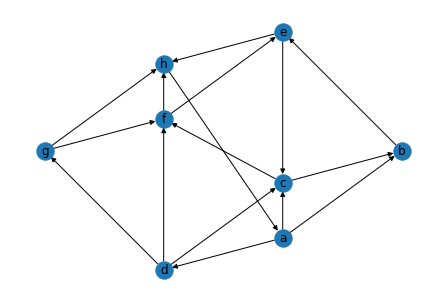

<Figure size 432x288 with 0 Axes>

In [14]:
import networkx as nx
import matplotlib.pyplot as plt
from networkx.drawing.nx_pydot import write_dot

G = nx.DiGraph()
G.add_nodes_from(nodes)
G.add_edges_from(arcs)

pos=nx.spectral_layout(G)
# pos = nx.kamada_kawai_layout(G) # alternative layout
nx.draw(G, pos=pos, with_labels=True)
#nx.draw_networkx_edge_labels(G,pos,edge_labels={e:G.edge[e[0]][e[1]]["capacity"] for e in G.edges()})
plt.show()
plt.savefig("graph.png")

#write_dot(G,"graph.dot")

and use dedicated algorithms to solve common problems like the max flow problem:


In [20]:
from networkx.algorithms.flow import shortest_augmenting_path

G = nx.DiGraph()
G.add_edge('a','b',capacity= 15)
G.add_edge('a','c',capacity= 5)
G.add_edge('a','d',capacity= 10)
G.add_edge('d','c',capacity= 4)
G.add_edge('c','b',capacity= 4)
G.add_edge('d','g',capacity= 9)
G.add_edge('d','f',capacity= 15)
G.add_edge('c','f',capacity= 8)
G.add_edge('b','e',capacity= 30)
G.add_edge('e','c',capacity= 6)
G.add_edge('g','f',capacity= 15)
G.add_edge('f','e',capacity= 15)
G.add_edge('g','h',capacity= 10)
G.add_edge('f','h',capacity= 10)
G.add_edge('e','h',capacity= 10)

flow_value, flow_dict = nx.maximum_flow(G, 'a', 'h', flow_func=shortest_augmenting_path)
print(flow_value)
print(flow_dict)


28
{'a': {'b': 13, 'c': 5, 'd': 10}, 'b': {'e': 13}, 'c': {'b': 0, 'f': 8}, 'd': {'c': 0, 'g': 9, 'f': 1}, 'g': {'f': 0, 'h': 9}, 'f': {'e': 0, 'h': 9}, 'e': {'c': 3, 'h': 10}, 'h': {}}


In [22]:
cut_value, partition = nx.minimum_cut(G, "a", "h")
reachable, non_reachable = partition


In [ ]:
‘partition’ here is a tuple with the two sets of nodes that define the minimum cut. 
You can compute the cut set of edges that induce the minimum cut as follows:


In [23]:
cutset = set()
for u, nbrs in ((n, G[n]) for n in reachable):
    cutset.update((u, v) for v in nbrs if v in non_reachable)
print(sorted(cutset))
cut_value == sum(G.edges[u, v]["capacity"] for (u, v) in cutset)

[('a', 'd'), ('c', 'f'), ('e', 'h')]


True